In [1]:
import pandas as pd

from features import Featured

people = pd.read_csv("../datasets/brazilian_names.csv")

df = pd.DataFrame([Featured.from_row(r) for r in people.to_dict(orient="records")])

In [2]:
from sklearn.preprocessing import OneHotEncoder

original_cols = ["ending_vowel", "ending_consonant"]
encoder_vowels = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
hot_ending_arr = encoder_vowels.fit_transform(df[original_cols])
hot_ending_df = pd.DataFrame(
    hot_ending_arr, columns=encoder_vowels.get_feature_names_out(original_cols)
).astype(bool)

df = pd.concat([df, hot_ending_df], axis=1).drop(columns=original_cols)
hot_ending_df.head(10)

,ending_vowel_a,ending_vowel_e,ending_vowel_i,ending_vowel_o,ending_vowel_u,ending_vowel_y,ending_vowel_None,ending_consonant_d,ending_consonant_h,ending_consonant_l,ending_consonant_m,ending_consonant_n,ending_consonant_r,ending_consonant_s,ending_consonant_x,ending_consonant_z,ending_consonant_None
0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
3,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
4,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
5,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
6,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True
7,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True
8,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
9,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [3]:
from typing import Any, Hashable


def partition(
    rows: pd.DataFrame, column: Hashable, breakpoint: Any
) -> tuple[pd.DataFrame, pd.DataFrame]:
    if isinstance(breakpoint, int | float):
        groups = rows.groupby(rows[column].apply(lambda n: n >= breakpoint))
    else:
        groups = rows.groupby(rows[column].apply(lambda n: n == breakpoint))

    if groups.groups.get(False) is None:
        return groups.get_group(True), pd.DataFrame({column: []})
    if groups.groups.get(True) is None:
        return pd.DataFrame({column: []}), groups.get_group(False)

    return groups.get_group(True), groups.get_group(False)


def gini(rows: pd.DataFrame, target: str) -> float:
    return 1 - sum(rows[target].value_counts(normalize=True) ** 2)


def find_best_split(rows: pd.DataFrame, target: str) -> tuple[float, Hashable, Any]:
    best = (0, "", None)  # gain, column, breakpoint
    uncertainty = gini(rows, target)

    for col, values in rows.items():
        if col == target:
            continue

        for val in values.unique():
            left, right = partition(rows, col, val)
            if len(left) == 0 or len(right) == 0:
                continue

            p = len(left) / (len(left) + len(right))
            gain = uncertainty - p * gini(left, target) - (1 - p) * gini(right, target)

            if gain >= best[0]:
                best = (gain, col, val)

    return best

In [4]:
from dataclasses import dataclass
from typing import Self


@dataclass
class Leaf:
    category: Hashable


@dataclass
class Decision:
    rows: pd.DataFrame
    target: str

    column: Hashable
    breakpoint: Any

    left: Self | Leaf
    right: Self | Leaf

    @classmethod
    def build_branch(cls, rows: pd.DataFrame, target: str) -> Self | Leaf:
        gain, col, breakpoint = find_best_split(rows, target)

        if gain == 0:
            return Leaf(str(rows["gender"].value_counts().idxmax()))

        left, right = partition(rows, col, breakpoint)

        return cls(
            rows,
            target,
            col,
            breakpoint,
            Decision.build_branch(left, target),
            Decision.build_branch(right, target),
        )

In [5]:
df.drop(columns=["syllables","normalized_syllables"], inplace=True)
df.head()

,ends_in_vowel,starts_in_vowel,starting_vowel,starting_consonant,nasal_count,sharp_count,a_count,i_count,u_count,e_count,...,ending_consonant_d,ending_consonant_h,ending_consonant_l,ending_consonant_m,ending_consonant_n,ending_consonant_r,ending_consonant_s,ending_consonant_x,ending_consonant_z,ending_consonant_None
0,True,False,o,j,1,0,0,0,0,1,...,False,False,False,False,False,False,False,False,False,True
1,True,False,i,c,0,1,0,1,0,1,...,False,False,False,False,False,False,False,False,False,True
2,True,False,e,f,1,0,1,0,0,1,...,False,False,False,False,False,False,False,False,False,True
3,True,False,a,m,0,0,2,0,0,0,...,False,False,False,False,False,False,False,False,False,True
4,True,True,a,None,1,0,2,0,0,2,...,False,False,False,False,False,False,False,False,False,True


In [6]:
import warnings
warnings.filterwarnings('ignore')
decision_tree = Decision.build_branch(df, "gender")

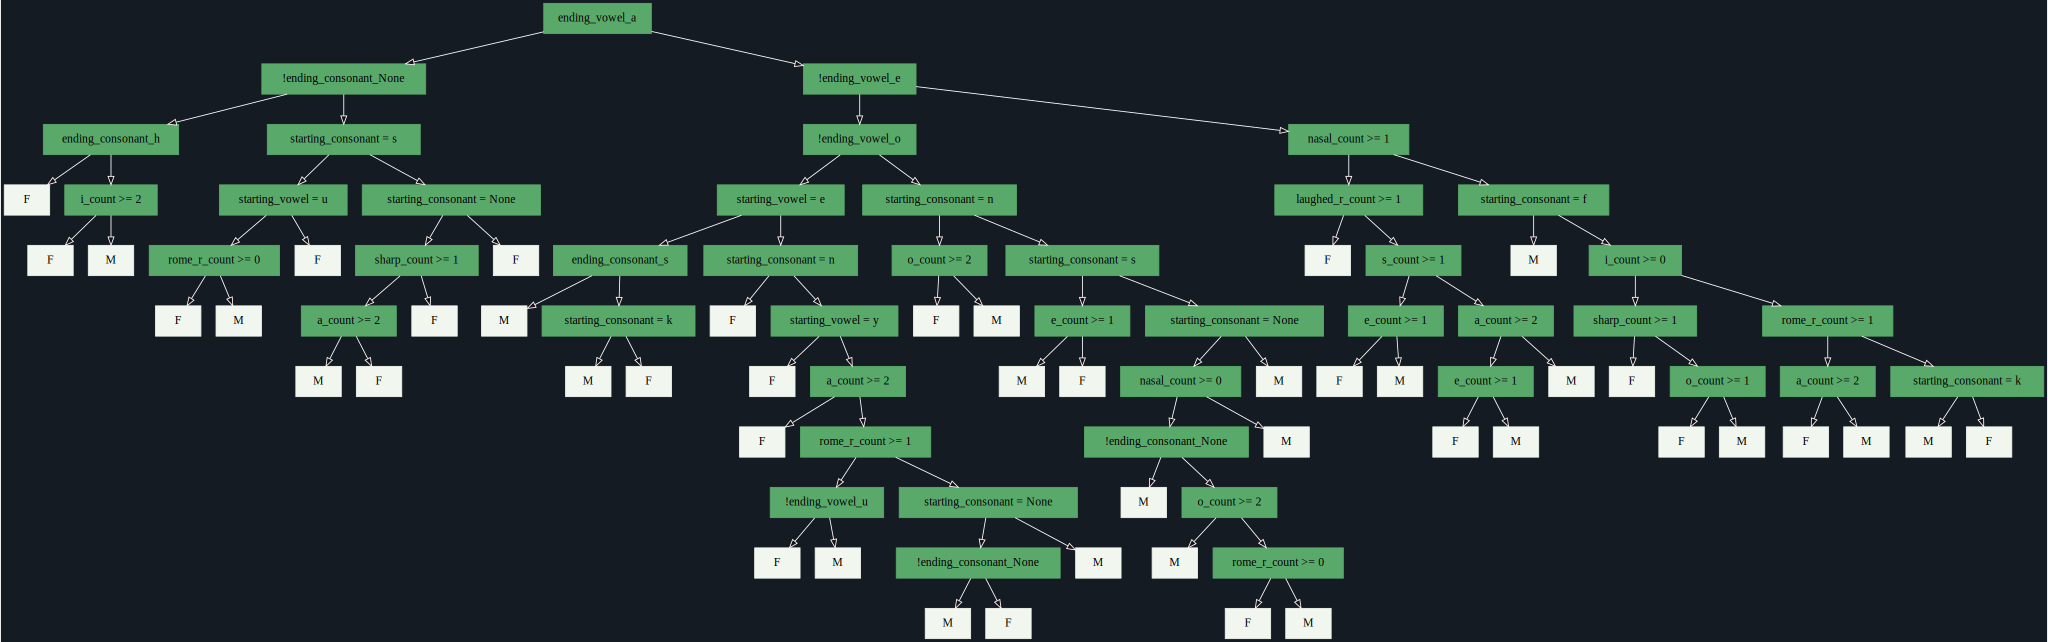

Tree saved as tree.png


In [7]:
import numpy as np
from graphviz import Digraph
from IPython.display import display


def visualize_tree(root: Decision | Leaf, filename="tree"):
    dot = Digraph()
    dot.attr(bgcolor="#151b23")
    dot.attr("node", style="filled", color="lightgray")
    dot.attr("edge", color="white", fontcolor="white", fillcolor="#1C0F13")

    def add_node(node, parent_name=None, edge_label=""):
        node_id = str(id(node))

        if isinstance(node, Leaf):
            label = node.category
            dot.node(node_id, label, shape="box", style="filled", color="#F1F7EE")
        elif isinstance(node, Decision):
            if isinstance(node.breakpoint, np.integer):
                label = f"{node.column} >= {node.breakpoint}"
            elif isinstance(node.breakpoint, np.bool):
                label = ("" if node.breakpoint else "!") + str(node.column)
            else:
                label = f"{node.column} = {node.breakpoint}"

            dot.node(node_id, label, shape="box", style="filled", color="#59a96a")
            add_node(node.left, node_id)
            add_node(node.right, node_id)

        if parent_name:
            dot.edge(parent_name, node_id, label=edge_label)

    add_node(root)
    display(dot)
    dot.render(filename, format="png", cleanup=True)
    print(f"Tree saved as {filename}.png")


visualize_tree(decision_tree)